In [1]:
# https://medium.com/@mariosrichards/political-patchwork-chart-1360289011a3?source=friends_link&sk=9ddbb607a04796a9411341363b48fb3a

In [1]:
dataset_name = "W16_comb"
df_list = [
           "BES_Panel",
#            "BES_reduced_with_na",
#            "BESnumeric"
#            "BES_reduced",
#            "BESnumeric"
          ]

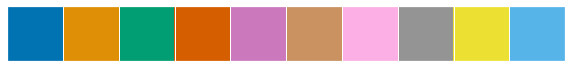

In [2]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re
sns.set()
sns.palplot(sns.color_palette("colorblind"))
from IPython.display import display, display_html, HTML
plt.rcParams["axes.grid"] = False

import Jupyter_module_loader
from utility import *
import gaussian_kde

import warnings
warnings.filterwarnings('ignore')

In [3]:
# you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
# %matplotlib inline
encoding = "ISO-8859-1"

(BES_code_folder, BES_small_data_files, BES_data_folder,
 BES_output_folder, BES_file_manifest, BES_R_data_files) = setup_directories()



In [4]:
global BES_Panel, BES_numeric, BES_reduced, BES_reduced_with_na, BES_non_numeric
data_subfolder = BES_data_folder + dataset_name + os.sep

(manifest, dataset_filename, dataset_description, dataset_citation,
 dataset_start, dataset_stop, dataset_wave) = get_manifest(dataset_name, BES_file_manifest)

for df in df_list:
    if df=="BES_Panel":
        globals()[df]  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))
    else:
        globals()[df]  = pd.read_msgpack(data_subfolder + df + '.msgpack' )
        globals()[df].replace(-1,np.nan,inplace=True)
  
# (var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)

In [5]:
pan_dataset_allr_values = pd.read_csv(BES_small_data_files + "pan_dataset_allr_values"+".csv")

In [59]:
# helper functions
global best_weight_series
def weighted_mean(series):
    return (series*best_weight_series.loc[series.index]).sum()/(best_weight_series.loc[series.index]).sum()

from pandas._libs.lib import is_integer

def weighted_qcut(values, weights, q, **kwargs):
    if is_integer(q):
        quantiles = np.linspace(0, 1, q + 1)
    else:
        quantiles = q
    order = weights[values.argsort()].cumsum()
    bins = pd.cut(order / order.iloc[-1], quantiles, **kwargs)
    return bins.sort_index()

# CHEATY FIX FOR WEIGHTING SEABORN KDES BEFORE THEY FIX SEABORN TO PASS WEIGHTS

# so we take in a series of weights - either assumes/force it to be non-null floats [0-inf)
# flip coins for the fractional parts of the weights to round up/down proportionately
# then replicate rows on the basis of the resulting weights

def lazy_weighted_indices(weights):
    x = weights.apply(lambda x: np.floor(x) if (np.random.rand() > x%1) else np.ceil(x)).astype('int')
    return flatten( [[weights.index[ind]]*x.values[ind] for ind in range(weights.shape[0])] )

def weighted_value_counts(x, wts, *args, **kwargs):
    normalize = kwargs.get('normalize', False)
    perc = kwargs.get('perc', False)
    decimal_places = kwargs.get('decimal_places', 2)
    suppress_raw_samplesize = kwargs.get('suppress_raw_samplesize', False)
    
    ascending = kwargs.get('ascending', True)
    c0 = x.name 
    c1 = wts.name
    df = pd.concat([x,wts],axis=1)
    xtmp = df.groupby(c0).agg({c1:'sum'}).sort_values(c1,ascending=False)
    s = pd.Series(index=xtmp.index, data=xtmp[c1], name=c0)
    s.name = "weighted_sample_size"
    if normalize:
        s = s / df[c1].sum()
        s.name = "weighted_sample_fraction"
    if normalize and perc:
        s = s*100
        s.name = "weighted_sample_percentage"
    s = s.round(decimal_places)
    if decimal_places==0:
        s=s.astype('int')
        
    if not suppress_raw_samplesize:
        output = pd.DataFrame([s,x[wts.notnull()].value_counts()]).T
        output.columns = [s.name,"raw_sample_size"]
        output.index.name = x.name
        output.sort_values(by=s.name,inplace=True, ascending=ascending)
    else:
        output = s
    return output

import random
 
def distinct_colors(n):
  ret = []
  r = 128+int(random.random() * 128)
  g = 128+int(random.random() * 128)
  b = 128+int(random.random() * 128)
  step = 128 / n
  for i in range(n):
    r += step
    g += step
    b += step
    r = 128+ (int(r) % 128)
    g = 128+ (int(g) % 128)
    b = 128+ (int(b) % 128)
    ret.append((r/255,g/255,b/255)) 
  return ret

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [7]:
Probably_didnt_vote_list = ["Don't know","No, did not vote","No, I did not vote"]
Didnt_vote_not_sure =BES_Panel["profile_turnout_2015"].apply(lambda x: x in Probably_didnt_vote_list).replace(np.nan,False)
if "Did not vote" not in BES_Panel["profile_past_vote_2015"].cat.categories:
    BES_Panel["profile_past_vote_2015"].cat.add_categories("Did not vote",inplace=True)
BES_Panel["profile_past_vote_2015"][Didnt_vote_not_sure] = "Did not vote"
Didnt_vote_not_sure =BES_Panel["profile_turnout_2017"].apply(lambda x: x in Probably_didnt_vote_list).replace(np.nan,False)
if "Did not vote" not in BES_Panel["profile_past_vote_2017"].cat.categories:
    BES_Panel["profile_past_vote_2017"].cat.add_categories("Did not vote",inplace=True)
BES_Panel["profile_past_vote_2017"][Didnt_vote_not_sure] = "Did not vote"
Didnt_vote_not_sure =BES_Panel["euroTurnoutRetroW16"].apply(lambda x: x in Probably_didnt_vote_list).replace(np.nan,False)
if "Did not vote" not in BES_Panel["euroElectionVoteW16"].cat.categories:
    BES_Panel["euroElectionVoteW16"].cat.add_categories("Did not vote",inplace=True)
BES_Panel["euroElectionVoteW16"][Didnt_vote_not_sure] = "Did not vote"
Didnt_vote_not_sure =BES_Panel["profile_eurefturnout"].apply(lambda x: x in Probably_didnt_vote_list).replace(np.nan,False)
if "Did not vote" not in BES_Panel["profile_eurefvote"].cat.categories:
    BES_Panel["profile_eurefvote"].cat.add_categories("Did not vote",inplace=True)
BES_Panel["profile_eurefvote"][Didnt_vote_not_sure] = "Did not vote"

BES_Panel["housing"] = BES_Panel["housing"].replace(9999,"Don't know").cat.remove_unused_categories()

cats = BES_Panel["profile_gross_household"].cat.categories
BES_Panel["profile_gross_household"].cat.rename_categories( [x.replace("Â","") for x in cats],inplace=True)
# party_colour_dict.update( {x:k for x,k in zip(cats,linear_colour_list[0:len(cats)+1]) if x != "Don't know"} )

In [8]:
# linear_colour_list = ['blue','cyan','yellow','olive','green','limegreen','orange','brown','pink','purple','red']
# howToReduceDeficit_cats = ['Only by increasing taxes','Mainly by increasing taxes, but also by cutting spending','An equal balance of spending cuts and tax increases', 
# 'Mainly by cutting spending, but with some tax increases','Only by cutting spending',"Don't know"   ]
# party_colour_dict.update( {x:k for x,k in zip(howToReduceDeficit_cats,linear_colour_list[0:len(howToReduceDeficit_cats)+1]) if x != "Don't know"} )

# leftRight_cats = ['Left', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Right',
#        "Don't know"]
# party_colour_dict.update( {x:k for x,k in zip(leftRight_cats,linear_colour_list[0:len(leftRight_cats)+1]) if x != "Don't know"} )

# cutsTooFarNational_cats = ['Not gone nearly far enough', 'Not gone far enough', 'About right', 'Gone too far','Gone much too far', "Don't know"]
# party_colour_dict.update( {x:k for x,k in zip(cutsTooFarNational_cats,linear_colour_list[0:len(cutsTooFarNational_cats)+1]) if x != "Don't know"} )

# taxSpendSelf_cats = ['Government should cut taxes a lot and spend much less on health and social services','1', '2', '3', '4', '5', '6', '7', '8', '9',       
#        'Government should increase taxes a lot and spend much more on health and social services', "Don't know"]
# party_colour_dict.update( {x:k for x,k in zip(taxSpendSelf_cats,linear_colour_list[0:len(taxSpendSelf_cats)+1]) if x != "Don't know"} )


# spend_cats = [ 'Spend much less','Spend less', 'Spend the same as now', 'Spend more','Spend much more',"Don't know"]
# party_colour_dict.update( {x:k for x,k in zip(spend_cats,linear_colour_list[0:len(spend_cats)+1]) if x != "Don't know"} )

# ageGroup_cats = ['Under 18', '18-25', '26-35', '36-45', '46-55', '56-65', '66+']
# party_colour_dict.update( {x:k for x,k in zip(ageGroup_cats,linear_colour_list[0:len(ageGroup_cats)+1]) if x != "Don't know"} )

# ageGroup_equalised_cats = BES_Panel["ageGroup_equalised"].astype(str).astype('category').cat.categories
# party_colour_dict.update( {x:k for x,k in zip(ageGroup_equalised_cats,linear_colour_list[0:len(ageGroup_equalised_cats)+1]) if x != "Don't know"} )

In [9]:
# get ages, clean up slightly

pan_dataset_ages = pd.read_csv( BES_small_data_files + "pan_dataset_ages"+".csv" )
pan_dataset_ages["equalisedAgeGroup_at_W1"].value_counts()

# equalisedAgeGroup_at_2019 = pd.qcut(pan_dataset_ages["Age_at_W1"]+5,q=8, precision=0)
# equalisedAgeGroup_at_2019 = weighted_qcut( pan_dataset_allr_values[y_var], weights=best_weight_series, q=8, precision=0 )


# BES_Panel["ageGroup_equalised"] = BES_Panel["ageGroup_equalised"].astype(str).astype('category')#.cat.categories
# nicer_age_group_labels = [x.replace("(","").replace("]","").replace(".0","").replace(" ","").replace(",","-") for x in BES_Panel["ageGroup_equalised"].cat.categories]
# BES_Panel["ageGroup_equalised"].cat.rename_categories(nicer_age_group_labels, inplace=True)

(30.0, 38.0]    11688
(38.0, 46.0]    11603
(60.0, 66.0]    11583
(12.0, 22.0]    11583
(53.0, 60.0]    11573
(22.0, 30.0]    11564
(66.0, 95.0]    11563
(46.0, 53.0]    11427
Name: equalisedAgeGroup_at_W1, dtype: int64

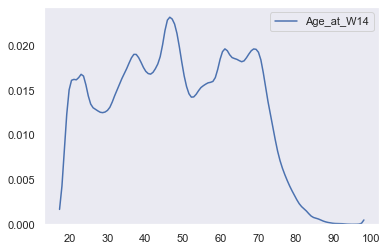

In [23]:
best_weight_variable = 'wt_new_W14'
mask = BES_Panel["wt_new_W14"].notnull()
best_weight_series = BES_Panel[best_weight_variable][mask]
df = pan_dataset_ages["Age_at_W14"][mask].copy()
# df.loc[lazy_weighted_indices(best_weight_series[mask])].hist(bins=50)
sns.kdeplot(df.loc[lazy_weighted_indices(best_weight_series[mask])],cut=0,bw=1)
# pan_dataset_ages["Age_at_W14"].hist(bins=50)

In [26]:
df.loc[lazy_weighted_indices(best_weight_series[mask])].median()

47.683376023522165

In [17]:
 search(BES_Panel,"wt_").sort_values(ascending=False).index[0]

'wt_new_W16'

In [53]:
party_colour_dict

{'Lab': 'red',
 'LAB': 'red',
 'Con': 'blue',
 'CON': 'blue',
 'UKIP': 'purple',
 'LD': 'orange',
 'Grn': 'green',
 'GRN': 'green',
 'BrexitParty': 'cyan',
 'BXP': 'cyan',
 'TIG': 'pink',
 'BNP': 'magenta',
 'SNP': 'yellow',
 'PC': 'olive',
 'Remain': 'yellow',
 'REMAIN': 'yellow',
 'Leave': 'blue',
 'LEAVE': 'blue',
 "Don't know": 'grey',
 'DK': 'grey',
 "Won't vote": 'black',
 'DNV': 'black',
 'NON': 'black',
 'Cameron': 'navy',
 'May': 'blue',
 'Osborne': 'darkblue',
 'Davidson': 'darkblue',
 'Boris': 'cyan',
 'Gove': 'darkviolet',
 'Rudd': 'teal',
 'Mogg': 'lightblue',
 'Hunt': 'grey',
 'Javid': 'dodgerblue',
 'Davis': 'lightblue',
 'Salmond': 'goldenrod',
 'Sturgeon': 'yellow',
 'Miliband': 'red',
 'Corbyn': 'red',
 'Blair': 'indianred',
 'AlanJohnson': 'pink',
 'Watson': 'chocolate',
 'McDonnell': 'darkred',
 'Jarvis': 'tomato',
 'Leonard': 'pink',
 'Wood': 'olive',
 'Price': 'olive',
 'Umunna': 'lightslategrey',
 'Berger': 'darkslategrey',
 'Soubry': 'mediumspringgreen',
 'Allen

In [10]:
replace_dict = {'Labour Party':"LAB", 
 'United Kingdom Independence Party (UKIP)':"UKIP",
 'Labour':"LAB",
 'Conservative Party':"CON",
 'Conservative':"CON",
 'Liberal Democrats':"LD",
 'Did not vote':"DNV",
 'Scottish National Party':"SNP",
 'Scottish National Party (SNP)':"SNP",
 'British National Party (BNP)':"BNP",
 'Green Party':"GRN",
 'Liberal Democrat':"LD",
 "Don't know":"DK",
 'Some other party':"OTH",
 'Veritas':"VER",
 'Plaid Cymru':"PC",
 'Other':"OTH",
 'Respect':"RES",
 'I would not vote':"DNV",
 'No - none':"NON",
 "Brexit Party":"BXP",
 'Change UK- The Independent Group':"CUK",
 "Leave the EU":"LEAVE",
 "Stay/remain in the EU":"REMAIN",}

party_colour_dict = {"Lab":"red","LAB":"red",
                     "Con":'blue',"CON":'blue',"UKIP":"purple","LD":"orange",
                     "Grn":'green',"GRN":'green',
                     "BrexitParty":"cyan","BXP":'cyan',
                     "TIG":"pink","BNP":"magenta",
                     "SNP":'yellow',"PC":'olive',
                     "Remain":"yellow","REMAIN":'yellow',"Leave":"blue","LEAVE":'blue',
                     "Don't know":"grey","DK":'grey',
                     "Won't vote":"black","DNV":'black',"NON":'black',
                     "Cameron":'navy',"May":'blue',
                     "Osborne":"darkblue","Davidson":"darkblue",
                     "Boris":'cyan',"Gove":"darkviolet","Rudd":'teal',"Mogg":"black" ,"Hunt":"grey" , "Javid":"dodgerblue", 
                     "Davis":"lightblue","Mogg":'lightblue',
                     "Salmond":'goldenrod',"Sturgeon":'yellow',
                     "Miliband":'red',"Corbyn":'red',"Blair":"indianred",
                     "AlanJohnson":'pink',"Watson":"chocolate","McDonnell":"darkred","Jarvis":'tomato',"Leonard":'pink',
                     "Wood":'olive',"Price":'olive',
                     "Umunna":"lightslategrey","Berger":'darkslategrey',"Soubry":'mediumspringgreen',"Allen":"darkslategrey",
                     "Clegg":'orange',"Farron":'orange',"Cable":'orange',"Rennie":'darkorange',
                     "Farage":'purple',"SEvans":"fuchsia","Nuttall":'indigo',"Batten":'indigo',
                     "Bennett":'green',"Lucas":'limegreen',"Harvie":"green","Berry":'darkgreen',"Bartley":'limegreen',
                     "Allow many fewer":"blue",
                     "1":'cyan',"Bad for economy":'cyan',"Undermines cultural life":'cyan','Strongly disagree':'cyan','It is completely necessary':'cyan',
                     "2":'yellow','Disagree':'yellow','It is important but not absolutely  necessary':'yellow',
                     "3":'olive','Neither agree nor disagree':'olive','It is not necessary but it would be desirable':'olive',
                     "4":'green', 'Agree':'green','It is completely unnecessary':'green',
                     "5":"limegreen",'Strongly agree':'limegreen',
                     "6":"orange",
                     "7":'brown',"Good for economy":'brown',"Enriches cultural life":'brown',
                     "8":'pink',
                     "9":'purple',
                     "Allow many more":'red',
#                      "The Sun": 'cyan',
#                      "The Guardian": 'green',
#                      "The Mirror / Daily Record":'red',
#                      "The Daily Mail / The Scottish Daily Mail":'blue',
#                      "The Times":'yellow',
                    }

big_set_of_colours = list(set(party_colour_dict.values()))
big_set_of_colours = [x for x in big_set_of_colours if x not in ['grey','lightslategrey','darkslategrey']]
big_set_of_colours = ['olive', 'purple', 'orange', 'red', 'cyan',
                      'limegreen', 'darkred', 'blue', 'chocolate',
                      'pink', 'darkgreen', 'yellow', 'darkorange','magenta', 'mediumspringgreen', 'tomato', 'teal',
                      'goldenrod',  'indianred']

In [11]:
search( BES_Panel, "generalElectionVote" )

generalElectionVoteW1              30342
generalElectionVoteW2              30228
generalElectionVoteW3              28111
generalElectionVoteW4              31440
generalElectionVoteUnsqueezeW4     20839
generalElectionVoteSqueezeW4        9370
generalElectionVoteW5              30377
generalElectionVotePostW5           3237
generalElectionVoteUnsqueezeW5     19417
generalElectionVoteSqueezeW5        6793
generalElectionVoteW6              27821
generalElectionVoteW7              30895
generalElectionVoteW8              33502
generalElectionVoteW9              30036
generalElectionVoteW10             30237
generalElectionVoteW11             30956
generalElectionVoteUnsqueezeW11    20488
generalElectionVoteSqueezeW11       9330
generalElectionVoteW12             34394
generalElectionVotePostW12          4335
generalElectionVoteUnsqueezeW12    21316
generalElectionVoteSqueezeW12       7389
generalElectionVoteW13             28297
generalElectionVoteW14             31063
generalElectionV

In [20]:
# %%time
from scipy import interpolate
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import colors
import matplotlib.patches as mpatches
from matplotlib import colors as mcolors
from matplotlib import cm
import matplotlib.ticker as ticker

sns.set(font_scale=2.5)

wave_descriptions = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"][["Wave No","Friendlier_Description"]].set_index("Wave No")

granularity = 21
x_var = 'Economic: Left <-> Right{gaussian-ish}'
y_var = 'Social: Liberalism <-> Conservatism{gaussian-ish}'
x_axis = pan_dataset_allr_values.columns[0].replace("200",str(granularity-1)).replace("{uniform}","")
y_axis = pan_dataset_allr_values.columns[1].replace("200",str(granularity-1)).replace("{uniform}","")
pan_dataset_allr_values[x_axis] = pd.qcut( pan_dataset_allr_values[x_var], q=granularity, labels=range(0,granularity))
pan_dataset_allr_values[y_axis] = pd.qcut( pan_dataset_allr_values[y_var], q=granularity, labels=range(0,granularity))



# how find to make the output grids (output_granularityXoutput_granularity)
output_granularity=800
# 
min_sample_size =100    
smoothing = 50.0

num_legend_columns = 3
max_wave = 17

# if break_single_variable then split a single categorical variable into a set of dummy variables
# if not break_single_variable then default to original format (like variables with a specific set of dropped categories)
break_single_variable = True
# if abbreviate_variables then shorten some of the names (e.g. party names shortform) AND REMOVE THE STUB (ptv/like)
abbreviate_variables = False
# if drop_cats then drop specific categories after dummying
##### MANUAL ADDITION
drop_cats = []
# ["nan"]
# ['Any other Asian background', 'Prefer not to say', 'Other ethnic group','White British','Black African']
# ["Other local daily morning newspaper","The Western Mail","The Independent","Other Newspaper","None"]#["Don't know","5"]


# add gridlines for underling value distribution (mostly flat)
pop_gridlines = True
# normalize_heights is true -> forces colours to range from min_surface_value and max_surface_value
normalize_heights = True
# within each (granularityxgranularity) gridpoint, use bes values for weighting
# one more reason to try to keep granularity low enough that this subsample is "reasonable"
use_bes_weights = True
# for BES variables with explicit waves, store the number, use the friendly description for the title
bes_wave_based = True

# if normalise_to_category_size true then rescale categories *as if they were the same size*
# i.e. you're not looking at absolute values but values *relative to that categories average*
normalise_to_category_size = False
# assign colours to any category not already covered
auto_update_colour_list = False
# attempt to automatically generate visually distinct colours - NOT WORKING!
use_dist_cols = False
# create a set of al_scale/lr_scale values *normalised to the BES weight distribution for a specific wave*
use_wave_weighted_values = True

# specify a region of the UK to limit the analysis to (None|"England"|"Scotland"|"Wales")
# region = "England"
region = "England"

##### MANUAL ADDITION
# stub_var = "partyId"
stub_var = "generalElectionVote"
title_base = "How much do you like or dislike each of the following party leaders?\n(Highest shown)"
override_scale_text = "0- Strongly dislike, 10- Strongly like"
# otherwise it will guess by looking at values (value/None)
override_max_z_size = 10.0

if normalise_to_category_size:
    scale_text = 'Overrepresentation factor'
else:
    scale_text = 'Probability of choosing option'
if override_scale_text:
    scale_text = override_scale_text

cbar_text = "Dominant Option (in territory size order)"

#['Bad for economy', '2', '3', '4', '5', '6', 'Good for economy',
#        "Don't know"]
# search(BES_Panel,"partyMemberNow")
# [1,2,3,4,5, 7, 9, 13] 
if use_bes_weights:
    aggfunc = weighted_mean
else:
    aggfunc = np.mean


if region is not None:
    specific_mask = (BES_Panel["country"]==region)# & (BES_Panel["profile_eurefvote"]=="Leave the EU")
else:
    specific_mask = BES_Panel["id"].notnull()
# ["W2","W6","W8","W12","W14","W16"]

skip_waves = [5]
skip_waves = [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11,13,15 ]
skip_waves = [1,2,3,4,5, 7, 9, 13]
skip_waves = [5,6,9,12]
# [1, 2, 3, 4, 7, 8, 10, 11][4, 6, 10, 11, 15] [1, 2, 3, 4, 6, 7, 12, 14]
skip_waves = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16 ]
skip_waves = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
# skip_waves = []
wave_list = ["W"+str(x) for x in list(range(1,max_wave)) if x not in skip_waves]
# wave_list = [str(x) for x in [2005,2010,2015,2017]]
# wave_list=  [""]
for wave in wave_list:
    if bes_wave_based:
        wave_no = int(wave.replace("W",""))
        title_extra = "\n"+wave_descriptions.loc[wave_no].values[0]#+"; "+region#+"&Leave-2016"
    else:
        title_extra = "\n"+wave#+"; "+region#+"&Leave-2016"

# treatment = "brexitself_surface"
#     treatment = "ptv_surface"+wave+"_" + region# + "_LEAVE2016"
    treatment = stub_var+"_surface"+wave#+"originalPC"#+"_"
    
    if region is not None:
            treatment = treatment+"_"+region
            title_extra = title_extra+"; "+region
    output_subfolder = create_subdir(BES_output_folder, treatment)

# party_list = ["Lab","Con","LD","Grn","UKIP","TIG","BrexitParty"]
# party_list = ["ptv"+x for x in party_list]
# party_list = ["brexitSelf"]
    if break_single_variable:
        
        if drop_cats:
            df1 = pd.get_dummies(BES_Panel[stub_var+wave].cat.remove_categories(drop_cats))
            df1.loc[BES_Panel[stub_var+wave].apply(lambda x: x in drop_cats or pd.isnull(x)).replace(np.nan,False),:]=np.nan
        else:
            df1 = pd.get_dummies(BES_Panel[stub_var+wave])
        mask = BES_Panel[stub_var+wave].notnull() & df1[df1.columns[0]].notnull() & specific_mask
#     eurevote_col_replace_dict = {"Don't know":"Don't know", "I would/will not vote":"Won't vote", "Leave the EU":"Leave",
#                   "Stay/remain in the EU":"Remain"}
        if abbreviate_variables:
            df1.columns = [replace_dict[x] for x in df1.columns]
        party_list = df1.columns

    else:
    ## sample size!
#         temp = match(BES_Panel,"like(.*)"+wave+"$", mask = specific_mask)
#         party_list = list(temp[temp>min_sample_size].index)
#         party_list = [x for x in party_list if re.match("like(.*)W\d+",x).groups()[0] in ["Con","Lab","SNP","PC","UKIP","Grn","BNP","LD","BrexitParty","TIG"]]
        
        temp = match(BES_Panel,stub_var+"(.*)"+wave+"$", mask = specific_mask)
        party_list = list(temp[temp>min_sample_size].index)
#         party_list = [x for x in party_list if re.match(stub_var+"(.*)W\d+",x).groups()[0] not in ["CandA","CandB","SNPExtra","Con","Lab","SNP","PC","UKIP","Grn","BNP","LD","BrexitParty","TIG","DUP"]]        
        party_list = [x for x in party_list if re.match(stub_var+"(.*)W\d+$",x).groups()[0] not in ["CandA","CandB","SNPExtra",'expgrp', 'ConExp', 'LabExp', 'LDExp', 'UKIPExp', 'GrnExp']]
        print(party_list)
#     temp = match(BES_Panel,"ptv.*"+wave+"$", mask = specific_mask)
#     party_list = list(temp[temp>min_sample_size].index)
    
    

    
    # specific_mask = 1

    interp_dict = {}

    largestN = 0


    for party in party_list:
        print(party)
    #     like_var = "ptv"+party
        like_var = party

        like_name = "probability to vote "+party
#         scale_text = ' 0-Very Unlikely, 10-Very Likely'
        title_text = title_base+like_var+title_extra
#         title_text = "Which party do you feel closest to: "+like_var+"?"+title_extra
        

    #     like_name = "Some people want to leave the European Union immediately without a deal.\nOther people would like to cancel Brexit and remain in the EU.\nWhere would you place yourself and the political parties on this scale?"
    #     scale_text = ' 0-Leave the EU without a deal, 10-Remain in the EU'    
    #     title_text = like_name

        # fix disordered categories!
        if "ptv" in like_var:
            BES_Panel[[x for x in BES_Panel.columns if like_var in x]] = \
                BES_Panel[[x for x in BES_Panel.columns if like_var in x]]\
                    .apply(lambda x: x.cat.reorder_categories(['Very unlikely','1', '2', '3', '4', '5', '6', '7', '8', '9',
                       'Very likely', "Don't know" ]))    
        elif "like" in like_var:
            BES_Panel[[x for x in BES_Panel.columns if like_var in x]] = \
                BES_Panel[[x for x in BES_Panel.columns if like_var in x]]\
                    .apply(lambda x: x.cat.reorder_categories(['Strongly dislike','1', '2', '3', '4', '5', '6', '7', '8', '9', "Don't know",
        'Strongly like']))                
        elif "immigEcon" in like_var:
            BES_Panel[[x for x in BES_Panel.columns if like_var in x]] = \
                BES_Panel[[x for x in BES_Panel.columns if like_var in x]]\
                    .apply(lambda x: x.cat.reorder_categories(['Bad for economy', '2', '3', '4', '5', '6', 'Good for economy',
       "Don't know"]))  
        elif "immigCultural" in like_var:
            BES_Panel[[x for x in BES_Panel.columns if like_var in x]] = \
                BES_Panel[[x for x in BES_Panel.columns if like_var in x]]\
                    .apply(lambda x: x.cat.reorder_categories(['Undermines cultural life', '2', '3', '4', '5', '6',
       'Enriches cultural life', "Don't know"]))     
        elif "immigrantsWelfareState" in like_var:
            BES_Panel[[x for x in BES_Panel.columns if like_var in x]] = \
                BES_Panel[[x for x in BES_Panel.columns if like_var in x]]\
                    .apply(lambda x: x.cat.reorder_categories(['Strongly disagree', 'Disagree', 'Neither agree nor disagree',
       'Agree','Strongly agree',  "Don't know"]))  
        elif "deficitReduce" in like_var:
            BES_Panel[[x for x in BES_Panel.columns if like_var in x]] = \
                BES_Panel[[x for x in BES_Panel.columns if like_var in x]]\
                    .apply(lambda x: x.cat.reorder_categories(['It is completely necessary','It is important but not absolutely  necessary','It is not necessary but it would be desirable','It is completely unnecessary',"Don't know"]))  
        elif "howToReduceDeficit" in like_var:
            BES_Panel[[x for x in BES_Panel.columns if like_var in x]] = \
                BES_Panel[[x for x in BES_Panel.columns if like_var in x]]\
                    .apply(lambda x: x.cat.reorder_categories(howToReduceDeficit_cats))  
        elif "leftRight" in like_var:
            BES_Panel[[x for x in BES_Panel.columns if like_var in x]] = \
                BES_Panel[[x for x in BES_Panel.columns if like_var in x]]\
                    .apply(lambda x: x.cat.reorder_categories(leftRight_cats))
        elif "taxSpendSelf" in like_var:
            BES_Panel[[x for x in BES_Panel.columns if like_var in x]] = \
                BES_Panel[[x for x in BES_Panel.columns if like_var in x]]\
                    .apply(lambda x: x.cat.reorder_categories(taxSpendSelf_cats))            
   


        # mean across all waves
    #     mean_like_Corbyn = BES_Panel[[x for x in BES_Panel.columns if like_var in x]]\
    #     .replace("Don't know",np.nan).apply(lambda x:x.cat.codes).replace(-1,np.nan).mean(axis=1)

#         mean_like_Corbyn = BES_Panel[[like_var]]\
#         .replace("Don't know",np.nan).apply(lambda x:x.cat.codes).replace(-1,np.nan).mean(axis=1)
        if break_single_variable:
            mean_like_Corbyn = df1[like_var]
            max_z_size = 1.0
        else:
            mean_like_Corbyn = BES_Panel[[like_var]]\
            .replace("Don't know",np.nan).apply(lambda x:x.cat.codes).replace(-1,np.nan).mean(axis=1)          
            mask = mean_like_Corbyn.notnull() & specific_mask
            max_z_size = mean_like_Corbyn.max()
            if override_max_z_size:
                max_z_size = override_max_z_size

#         
        N_equal_text = " (N="+str(mask.sum())+")"
        
        global best_weight_series
        best_weight_variable = search(BES_Panel,"wt_(core|full|new|fresh)",mask=mask).sort_values(ascending=False).index[0]
        best_weight_series = BES_Panel[best_weight_variable]
        print(best_weight_variable)
        
        if use_wave_weighted_values:
            mask = mask&best_weight_series.notnull()
            x_axis = pan_dataset_allr_values.columns[0].replace("200",str(granularity-1)).replace("{uniform}","")+"{"+best_weight_variable+"}"
            y_axis = pan_dataset_allr_values.columns[1].replace("200",str(granularity-1)).replace("{uniform}","")+"{"+best_weight_variable+"}"
            # only update if not already present
            if x_axis not in pan_dataset_allr_values.columns:
                pan_dataset_allr_values[x_axis] = weighted_qcut( pan_dataset_allr_values[x_var], weights=best_weight_series, q=granularity, labels=range(0,granularity) )
            if y_axis not in pan_dataset_allr_values.columns:
                pan_dataset_allr_values[y_axis] = weighted_qcut( pan_dataset_allr_values[y_var], weights=best_weight_series, q=granularity, labels=range(0,granularity) )
        

        likeCorbyn_heatmap = pd.crosstab(index = pan_dataset_allr_values[y_axis][mask],
                    columns = pan_dataset_allr_values[x_axis][mask],
                    values = mean_like_Corbyn[mask],
                    aggfunc = aggfunc)

        plt.figure(figsize = (16,10))
        ax = sns.heatmap(data = likeCorbyn_heatmap.replace(np.nan,-1),
                    cbar_kws={'label': like_var+ scale_text})
        ax.invert_yaxis()

        plt.xlim([0,granularity])
        plt.ylim([0,granularity])
        plt.xlabel(x_axis);
        plt.ylabel(y_axis);
        plt.title(title_text+N_equal_text)
        plt.savefig(BES_output_folder + treatment + os.sep + clean_filename(like_var) +"_by_PC_heatmap" + ".png",
                   bbox_inches='tight')
        plt.close()

        #### INTERPOLATE

        size = likeCorbyn_heatmap.columns.max()
        x,y = np.mgrid[ 0:size:granularity*1j, 0:size:granularity*1j ]
        z =  likeCorbyn_heatmap.values.flatten()
        non_null_mask = ~np.isnan(z)
        x = x.flatten()[non_null_mask]
        y = y.flatten()[non_null_mask]
        z = z[non_null_mask]
        print("There are " + str(np.sum(~non_null_mask)) + " nulls") 
        interp_dict[party]=interpolate.Rbf(x,y,z,function='linear',smooth=smoothing)


        grid=np.mgrid[0:size:1j*output_granularity,
                       0:size:1j*output_granularity]
        result=interp_dict[party](grid[0,:,:],grid[1,:,:]);
        plt.figure(figsize=(14,14));
        img = plt.imshow(result,interpolation = 'none',origin ='lower',
                  extent = (0,granularity-1,0,granularity-1)); #Apparently nice smooth linear-ish interpolation
        plt.grid(None)
        plt.locator_params(nbins=5)
        cbar = plt.colorbar(img,shrink=0.5, aspect=5, label =  like_var+ scale_text );#, title = "\n".join(scale_text.split(",")) );
        plt.xlabel(x_axis);
        plt.ylabel(y_axis);
        plt.title(title_text+N_equal_text)
        plt.savefig(BES_output_folder + treatment + os.sep + clean_filename(like_var) +"_by_PC_interpolated" + ".png",
                   bbox_inches='tight')
        plt.close()



        ### 3D Surface

        X,Y = grid
        Z = result.reshape(X.shape)
        # this seems to flip the axes!
        # Plot the surface.
        fig = plt.figure(figsize=(14,14));

        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                               linewidth=0, antialiased=False)

        ax.set_title(title_text+N_equal_text, fontsize=18)
        # Customize the z axis.
        ax.set_zlim(0, max_z_size);
#         ax.zaxis.set_major_locator(LinearLocator(10));
        plt.xlabel(y_axis, fontsize=14);
        plt.ylabel(x_axis, fontsize=14);
        ax.set_zlabel(like_var+ scale_text, fontsize=14);
        plt.locator_params(nbins=5)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.tick_params(axis='both', which='minor', labelsize=14)


        # Add a color bar which maps values to colors.
        fig.colorbar(surf, shrink=0.5, aspect=5);

    #     fig.show();
        fig.savefig(BES_output_folder + treatment + os.sep + clean_filename(like_var) +"_by_PC_3D" + ".png",
                   bbox_inches='tight')
        plt.close()
        
        if mask.sum()>largestN:
            largestN = mask.sum()
        

    ###################

    
    overall_N_equal_text = " (N="+str(largestN)+")"

#     output_granularity=500
    grid=np.mgrid[0:size:1j*output_granularity,
                   0:size:1j*output_granularity]

    df = pd.DataFrame()
    for party in party_list:
        df[party]=interp_dict[party](grid[0,:,:],grid[1,:,:]).flatten()

    #df["max"] = df.max(axis=1)
    # df["leading_party"] = df.apply(lambda x: x.index[x[df.columns]==x["max"]][0],axis=1) # slow ~ 30s
    # only works with break_single_variable = True
    if normalise_to_category_size:
        temp = BES_Panel[stub_var+wave].cat.remove_categories(drop_cats).value_counts()
        temp = pd.Series(temp/temp.sum()).loc[df.columns]
        df = df.divide(temp,axis=1)
    

    df["leading_party"] = df.idxmax(axis=1)
    df["max"] = df.max(axis=1)/max_z_size
    surf_min = df["max"].min()
    surf_max = df["max"].max()
    if normalize_heights:       
        df["max"] = ( df["max"]-surf_min ) / (surf_max-surf_min )

    ######################

    dominant_parties = list(df["leading_party"].value_counts().index)
    display(df["leading_party"].value_counts())

# "Remain":"yellow","Leave":"blue",

#     if not break_single_variable:
#         dominant_parties = [re.match(stub_var+"(.*)"+wave+"$",x).groups()[0] for x in dominant_parties]
    
#     ageGroup_cats = ['Under 18', '18-25', '26-35', '36-45', '46-55', '56-65', '66+']
    if auto_update_colour_list:
        if not abbreviate_variables:
            party_colour_dict.update( {x:k for x,k in zip(dominant_parties,big_set_of_colours[0:len(dominant_parties)+1]) if x not in party_colour_dict.keys()} )
        else:
            abbrev_dominant_parties = [re.match(stub_var+"(.*)"+wave+"$",x).groups()[0] for x in dominant_parties]
            party_colour_dict.update( {x:k for x,k in zip(abbrev_dominant_parties,big_set_of_colours[0:len(abbrev_dominant_parties)+1]) if x not in party_colour_dict.keys()} )



    legend_patch_list = []

    count = 0
    colour_list = []
    repl_dict = {}
    for party in dominant_parties:
        repl_dict[party] = count

        party_name = party
        if abbreviate_variables:
            party_name = re.match(stub_var+"(.*)W\d+",party).groups()[0]
        colour = party_colour_dict[ party_name ]
        colour_list.append( colour )
        legend_patch_list.append( mpatches.Patch(color=colour, label=party_name) )
        count=count+1

    #######################


#     cmap = colors.ListedColormap(colour_list)
#     bounds=list(range(0,np.max(list(repl_dict.values()))+2))

#     norm = colors.BoundaryNorm(bounds, cmap.N)
#     colour_list = ["yellow","blue"]
    


    color_dict = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)


#     colour_list = ['yellow','blue']
    eta = .001
    cdict = {'red':[],'green':[],'blue':[],'alpha':[]}

    n = len(colour_list)
    anchor_pts = np.linspace(0.0,1.0,n+1)
    
    if use_dist_cols:
        dist_col_list = distinct_colors(n)    
    

    for col_no in range(0,n):
        x = anchor_pts[col_no]
        col = mcolors.to_rgba( color_dict[ colour_list[col_no] ] )
        if use_dist_cols:
            col = dist_col_list[col_no]
        cdict['red'].append(   (x,col[0],col[0]) )
        cdict['green'].append( (x,col[1],col[1]) )
        cdict['blue'].append(  (x,col[2],col[2]) )
        cdict['alpha'].append(  (x,0.0,0.0 ) )

        x = anchor_pts[col_no+1]-eta
        if col_no ==(n-1):
            x = x+eta
        col = mcolors.to_rgba( color_dict[ colour_list[col_no] ] )
        if use_dist_cols:
            col = dist_col_list[col_no]        
        cdict['red'].append(   (x,col[0],col[0]) )
        cdict['green'].append( (x,col[1],col[1]) )
        cdict['blue'].append(  (x,col[2],col[2]) )
        cdict['alpha'].append(  (x,1.0,1.0 ) )

    plt.register_cmap(name='test', data=cdict)

    df["leading_party"] = df["leading_party"].replace(repl_dict).astype('float')
#     df["leading_party"] = 1.0-df["leading_party"]

    res = df["leading_party"].values.reshape((output_granularity,output_granularity))
    res = (df["leading_party"]+df["max"]).values.reshape((output_granularity,output_granularity))

    ######################
#     plt.rcParams["axes.grid"] = False
#     title_text = "Which parties have the highest Probability To Ever Vote\nat any given Political Compass position?"+title_extra
#     title_text = "How would/did/would you vote (again) in an EU referendum?"+title_extra
#     title_text = "How would you vote in the next General Election?"+title_extra
    patchwork_title_text = title_base+title_extra
    

    # make a color map of fixed colors
    plt.figure(figsize=(15,14));
    # tell imshow about color map so that only set colors are used
    print(np.min(res),np.max(res),len(colour_list))
    img = plt.imshow(res/len(colour_list), origin='lower',
                  cmap='test',interpolation='none',norm=None,vmin=0.0, vmax=1.0,
                  extent = (0,granularity-1,0,granularity-1) )
#                         cmap=cmap, norm=norm,



    cmap = plt.get_cmap('test')
    new_cmap = truncate_colormap(cmap, 0.0, 1.0/n, 1000)    
    
    plt.colorbar(cm.ScalarMappable(norm=cm.colors.Normalize(vmax=surf_min*max_z_size, vmin=surf_max*max_z_size),
                                   cmap=new_cmap),shrink=0.5, label = scale_text, format=ticker.FormatStrFormatter('%.2g'))
    
    plt.xlabel(x_axis);
    plt.ylabel(y_axis);
#     plt.rcParams["axes.grid"] = False
    plt.title(patchwork_title_text+overall_N_equal_text)
    plt.locator_params(nbins=5)
    plt.grid(None)

    # add gridlines for underlying distribution
    if pop_gridlines==True:
        hmax = sns.kdeplot(pan_dataset_allr_values[x_axis][specific_mask],pan_dataset_allr_values[y_axis][specific_mask],
                           cut=0, alpha=.2)
        hmax.collections[0].set_alpha(0)


    plt.legend(handles=legend_patch_list, bbox_to_anchor=(0.5, -0.095),loc="upper center",
               fancybox=True, shadow=True, title=cbar_text, ncol=num_legend_columns, fontsize=14)
    plt.annotate(dataset_citation, (0,0), (0, -170-10*np.ceil(n/num_legend_columns)),
                     xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7) ;     


    plt.savefig(BES_output_folder + treatment + os.sep + "all_ptv_surfaces"+"_by_PC_territory" + ".png",
                bbox_inches='tight')
    plt.close()

    ######################################

    X,Y = grid
    Z = df["max"].values.reshape(X.shape)
    # this seems to flip the axes!
    # Plot the surface.
    fig = plt.figure(figsize=(14,14));

    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    ax.set_title(title_text+overall_N_equal_text, fontsize=18)

    # Customize the z axis.
    ax.set_zlim(0, max_z_size);
#     ax.zaxis.set_major_locator(LinearLocator(10));
    plt.xlabel(y_axis, fontsize=14);
    plt.ylabel(x_axis, fontsize=14);
    plt.locator_params(nbins=5)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    ax.set_zlabel(patchwork_title_text+overall_N_equal_text, fontsize=14);
    
    fig.savefig(BES_output_folder + treatment + os.sep + "all_ptv_surfaces" +"_by_PC_3D" + ".png",
               bbox_inches='tight')
    plt.close()
    ################

    plt.figure(figsize=(14,14));
    img = plt.imshow(Z,interpolation = 'none',origin ='lower',
              extent = (0,granularity-1,0,granularity-1)); #Apparently nice smooth linear-ish interpolation
    plt.grid(None)
    plt.locator_params(nbins=5)
    cbar = plt.colorbar(img,shrink=0.5, aspect=5, label = scale_text);
    plt.xlabel(x_axis);
    plt.ylabel(y_axis);
    plt.title(patchwork_title_text+overall_N_equal_text)
    plt.savefig(BES_output_folder + treatment + os.sep + "all_ptv_surfaces" +"_by_PC_interpolated" + ".png",
                bbox_inches='tight')
    plt.close()
gc.collect()

# plt.xticks(fontsize=14, rotation=90)

British National Party (BNP)
wt_full_W1
There are 0 nulls
Conservative
wt_full_W1
There are 0 nulls
Don't know
wt_full_W1
There are 0 nulls
Green Party
wt_full_W1
There are 0 nulls
I would not vote
wt_full_W1
There are 0 nulls
Labour
wt_full_W1
There are 0 nulls
Liberal Democrat
wt_full_W1
There are 0 nulls
Other
wt_full_W1
There are 0 nulls
Plaid Cymru
wt_full_W1
There are 0 nulls
Scottish National Party (SNP)
wt_full_W1
There are 0 nulls
United Kingdom Independence Party (UKIP)
wt_full_W1
Warning, filename truncated because it was over 30. Filenames may no longer be unique
There are 0 nulls
Warning, filename truncated because it was over 30. Filenames may no longer be unique
Warning, filename truncated because it was over 30. Filenames may no longer be unique


Labour                                      375462
Conservative                                260495
United Kingdom Independence Party (UKIP)      4043
Name: leading_party, dtype: int64

KeyError: 'Labour'

In [19]:
party

'LAB'

In [60]:
### build animated gif


filename_list = []
sorted_wavelist = []
skip_waves = [ 14 ]
wave_list = ["W"+str(x) for x in list(range(1,max_wave)) if x not in skip_waves]
for wave in wave_list:
    
    wave_no = int(wave.replace("W",""))
    sorted_wavelist.append(wave_no)
#     treatment = "ptv_surface"+wave+"_" + region + "_LEAVE2016"
    treatment = stub_var+"_surface"+wave#+"originalPC"#+"_"
    treatment = stub_var+"_surface"+wave
    if region is not None:
        treatment = treatment+"_"+region
#     treatment = "eurefvote_surface"+wave+"originalPC"
#     C:\Users\Marios\Documents\GitHub\BES_analysis\BES_analysis_output\leftRight_minusDKs_surfaceW16
    filename_list.append( BES_output_folder + treatment + os.sep + "all_ptv_surfaces"+"_by_PC_territory" + ".png" )



import imageio


images = []
for filename in filename_list:
    images.append(imageio.imread(filename))
images.append(imageio.imread(filename)) # last slide delay doesn't seem to be being respected on twitter - so add the last one twice
sorted_wavelist.append(wave_no)
imageio.mimsave(BES_output_folder + treatment + os.sep +'animated_ptv_surfaces.gif', images,'GIF',
                duration=[6.0 if x==np.min( sorted_wavelist ) or x==np.max( sorted_wavelist ) else 3.0 for x in sorted_wavelist])  

In [61]:
BES_output_folder + treatment + os.sep +'animated_ptv_surfaces.gif'

'../BES_analysis_output/ptv_surfaceW16_England\\animated_ptv_surfaces.gif'

In [ ]:
######## Creating full set of ages from BES data


In [102]:
# just ageWX variables

ageW_vars = BES_Panel[ search(BES_Panel,"^ageW\d+|^age$|^Age$").index ].copy().astype('float32')
ageW_vars[ageW_vars<15] = np.nan
ageW_vars[ageW_vars>105] = np.nan
ageW_vars.loc[33553,"ageW8"] = np.nan
ageW_vars.loc[739,"ageW1"] = np.nan
ageW_vars.loc[739,"Age"] = np.nan
ageW_vars.loc[2944,"ageW1"] = np.nan
ageW_vars.loc[2944,"Age"] = np.nan
ageW_vars.loc[6819,"ageW14"] = np.nan
ageW_vars.notnull().sum(axis=1).value_counts().sort_index()

age_var_num = ageW_vars.notnull().sum(axis=1)
obvious_disparities = (ageW_vars.max(axis=1)-ageW_vars.min(axis=1))>=9
obvious_disparities.sum()

age_var_num[obvious_disparities].value_counts().sort_index()
# not much to be done about those 7!

easy_filterable = ((obvious_disparities) &  (age_var_num>5))
len( easy_filterable[easy_filterable].index )

dict_of_bad_variables = {}
for ind in easy_filterable[easy_filterable].index:
#     first = easy_filterable[easy_filterable].index[0]
    mean_age = ageW_vars.loc[ind].mean()
    age_abs_dev = np.abs(ageW_vars.loc[ind] - mean_age)

    bad_variable = age_abs_dev.dropna().sort_values(ascending=False).index[0]
    bad_deviation = age_abs_dev.dropna().sort_values(ascending=False).values[0]
    dict_of_bad_variables[ind] = (bad_variable,bad_deviation)
    
    ageW_vars.loc[ind,bad_variable] = np.nan
dict_of_bad_variables    

from scipy.optimize import curve_fit

def match_age(x, ageW7c, ageW8c, ageW9c,ageW11c,ageW12c,ageW13c,ageW14c,ageW15c,ageW16c):
    x = pd.DataFrame(x, columns = ['ageW1', 'ageW7', 'ageW8', 'ageW9', 'ageW11', 'ageW12', 'ageW13',
       'ageW14', 'ageW15', 'ageW16', 'Age']).replace(0, np.nan)
    x["ageW7"]  -= ageW7c
    x["ageW8"]  -= ageW8c
    x["ageW9"]  -= ageW9c    
    x["ageW11"] -= ageW11c
    x["ageW12"] -= ageW12c
    x["ageW13"] -= ageW13c
    x["ageW14"] -= ageW14c
    x["ageW15"] -= ageW15c
    x["ageW16"] -= ageW16c     
    return x.std(axis=1)
    
    

comparisons_possible = ageW_vars.notnull().sum(axis=1)>=2
ydata = np.zeros(sum(comparisons_possible))

popt, pcov = curve_fit(match_age, ageW_vars[comparisons_possible].replace(np.nan,0).values, ydata, p0=[2,2,2, 3,3,3, 4,2,0])

popt

ageW_vars_matched = ageW_vars.copy()
ageW_vars_matched["ageW7"]  -= popt[0]
ageW_vars_matched["ageW8"]  -= popt[1]
ageW_vars_matched["ageW9"]  -= popt[2]    
ageW_vars_matched["ageW11"] -= popt[3]
ageW_vars_matched["ageW12"] -= popt[4]
ageW_vars_matched["ageW13"] -= popt[5]
ageW_vars_matched["ageW14"] -= popt[6]
ageW_vars_matched["ageW15"] -= popt[7]
ageW_vars_matched["ageW16"] -= popt[8]

# ageW_vars_matched["age"] -= 2    
# ageW_vars_matched["Age"] -= 0

# max_minus_min = ageW_vars_matched.max(axis=1) - ageW_vars_matched.min(axis=1)
# max_minus_min[max_minus_min>4].value_counts().sum()

age_var_num = ageW_vars_matched.notnull().sum(axis=1)
obvious_disparities = (ageW_vars_matched.max(axis=1)-ageW_vars_matched.min(axis=1))>=4
obvious_disparities.sum()

age_var_num[obvious_disparities].value_counts().sort_index()
# not much to be done about those 7!


easy_filterable = ((obvious_disparities) &  (age_var_num>=3))
len( easy_filterable[easy_filterable].index )

dict_of_bad_variables = {}
for ind in easy_filterable[easy_filterable].index:
#     first = easy_filterable[easy_filterable].index[0]
    mean_age = ageW_vars_matched.loc[ind].mean()
    age_abs_dev = np.abs(ageW_vars_matched.loc[ind] - mean_age)

    bad_variable = age_abs_dev.dropna().sort_values(ascending=False).index[0]
    bad_deviation = age_abs_dev.dropna().sort_values(ascending=False).values[0]
    dict_of_bad_variables[ind] = (bad_variable,bad_deviation)
    
    ageW_vars.loc[ind,bad_variable] = np.nan
    ageW_vars_matched.loc[ind,bad_variable] = np.nan
dict_of_bad_variables    

0         3
1     24574
2     17238
3      8195
4      6494
5      5915
6      5461
7      6372
8      5002
9      5341
10     4853
11     3139
dtype: int64

In [129]:
# respondents that post cleaning have *no* age variables?
# substitute in pred_ages (better than obvious gibberish/nothing!)
ageW_vars.loc[(age_var_num==0)]
pred_ages.loc[(age_var_num==0)]
ageW_vars_matched.loc[12229,"Age"] = 41.688381
ageW_vars_matched.loc[62207,"Age"] = 27.849688

Age_at_W1 = ageW_vars_matched.mean(axis=1)
Age_at_W1_rounded = Age_at_W1.round()
# fill in the last 3 gaps with averages
Age_at_W1_rounded.loc[62208] = 71
Age_at_W1_rounded.loc[75417] = 45
Age_at_W1_rounded.loc[78141] = 45
Age_at_W1.loc[62208] = 71
Age_at_W1.loc[75417] = 45
Age_at_W1.loc[78141] = 45

# pd.cut(Age_at_W1, bins = [ 18, 25,35,45,55,65])
age_group_cats =  ['Under 18', '18-25', '26-35', '36-45', '46-55', '56-65', '66+']
standard_age_groups = pd.IntervalIndex.from_arrays([0, 18, 26,36,46,56,66], [17, 25, 35, 45, 55, 65, 120], closed = 'both')
standardAgeGroup_at_W1 = pd.cut(Age_at_W1_rounded, standard_age_groups, labels = age_group_cats)
standardAgeGroup_at_W1.cat.rename_categories(age_group_cats, inplace=True)
standardAgeGroup_at_W1.value_counts().sort_index()

# equal_length_age_groups = pd.IntervalIndex.from_arrays([13, 18, 26,36,46,56,66], [17, 25, 35, 45, 55, 65, 120], closed = 'both')
equalLengthAgeGroup_at_W1 = pd.cut(Age_at_W1_rounded, range(10,96,5) )
# standardAgeGroup_at_W1.cat.rename_categories(BES_Panel["ageGroup"].cat.categories, inplace=True)
equalLengthAgeGroup_at_W1.value_counts().sort_index()

equalisedAgeGroup_at_W1 = pd.qcut(Age_at_W1,q=8, precision=0)
equalisedAgeGroup_at_W1.value_counts().sort_index()


In [229]:
# Age_at_W1 = ageW_vars_matched.mean(axis=1)
# Age_at_W1_rounded = Age_at_W1.round()
Age_at_W7 = Age_at_W1 + popt[0]
Age_at_W8 = Age_at_W1 + popt[1]
Age_at_W9 = Age_at_W1 + popt[2]
Age_at_W11 = Age_at_W1 + popt[3]
Age_at_W12 = Age_at_W1 + popt[4]
Age_at_W13 = Age_at_W1 + popt[5]
Age_at_W14 = Age_at_W1 + popt[6]

standardAgeGroup_at_W1
equalisedAgeGroup_at_W1

pan_dataset_ages = pd.concat([BES_Panel["id"].astype('int'),
                              Age_at_W1,
                              Age_at_W1_rounded,
                              Age_at_W7,
                              Age_at_W8,
                              Age_at_W9,
                              Age_at_W11,
                              Age_at_W12,
                              Age_at_W13,
                              Age_at_W14,
                              standardAgeGroup_at_W1,
                              equalisedAgeGroup_at_W1,
                              equalLengthAgeGroup_at_W1]
                              ,axis=1)

pan_dataset_ages.columns = ["id",
                            "Age_at_W1","Age_at_W1_rounded","Age_at_W7","Age_at_W8","Age_at_W9",
                            "Age_at_W11","Age_at_W12","Age_at_W13","Age_at_W14",
                            "standardAgeGroup_at_W1","equalisedAgeGroup_at_W1","equalLengthAgeGroup_at_W1"]
pan_dataset_ages["Age_at_W1_rounded"] = pan_dataset_ages["Age_at_W1_rounded"].astype('int8')

# pan_dataset_ages["id"] = BES_Panel["id"].astype('int')

pan_dataset_ages.to_csv(    BES_small_data_files + "pan_dataset_ages"+".csv", index=False)
pan_dataset_ages.to_msgpack(BES_small_data_files + "pan_dataset_ages"+".msgpack")

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.


In [ ]:
### Thoughts about Labour/LibDems and Welfarism

In [8]:
search(BES_Panel,"wt_new")

wt_new_W11           30956
wt_new_W14           31063
wt_new_W15           30842
wt_new_W16           37959
wt_new_W1_W16         2427
wt_new_W6W7          21081
wt_new_W2W6          23115
wt_new_W2W6W7        17076
wt_new_W9_W13        12562
wt_new_W12           34394
wt_new_W13           31135
wt_new_W1_W11         6473
wt_new_W1_W12         5833
wt_new_W1_W13         5301
wt_new_W6_W11         9373
wt_new_W6_W12         8398
wt_new_W6_W13         7622
wt_new_W11_W13       21520
wt_new_W13W16        14647
wt_new_W13_result    31135
wt_new_W6W16          9587
wt_new_W2W16          8388
wt_new_W9            30036
wt_new_W8            33502
wt_new_W7            30895
wt_new_W6            30073
wt_new_W13W14        20393
wt_new_W9_W14         9723
wt_new_W6_W14         6034
wt_new_W1_W14         4191
wt_new_W6W13         15849
wt_new_W7W13         18493
wt_new_W10           30237
dtype: int64

In [15]:
from cycler import cycler
global BES_Panel
def nice_bar_plot(ser1, ser2, normalize = 'columns', sort_labels=False, output_folder = BES_output_folder,
                  text_width=8, text_fontsize=14, min_sample_size=100, title=None, drop_insig=True, fuckErrors=True,
                  mask=1, title_fontsize=14, color=None, label=None, char_limit=40):
    var1 = ser1.name
    var2 = ser2.name
    
    mask = ser1.notnull() & ser2.notnull() & mask
    ids = ser1[mask].index
    ser1 = ser1[mask]
    ser2 = ser2[mask]
#     ct = pd.crosstab( ser1, ser2,
#                       values= get_all_weights(mask), aggfunc=sum, normalize=normalize)*100
    ct = pd.crosstab( ser1, ser2,
                      values= get_all_weights(ids), aggfunc=sum, normalize=normalize)*100    
    if sort_labels:
        sorted_labels = list(ser2.value_counts().index)
    else:
        sorted_labels = list(ser2.cat.categories)
           

    unweighted = pd.crosstab( ser1, ser2 )
    errors = 100 * np.sqrt(unweighted)/unweighted     

    labels_by_sample_size = {unweighted.sum().values[x]:sorted_labels[x]+" (N="+str(unweighted.sum().values[x])+")" for x in range(0,len(sorted_labels))}    
    labels_by_sample_size = {sorted_labels[x]+" (N="+str(unweighted.sum().values[x])+")":unweighted.sum().values[x] for x in range(0,len(sorted_labels))}    
    labels_restricted = [x for x in labels_by_sample_size.keys() if labels_by_sample_size[x] > min_sample_size] 
#     return labels_by_sample_size, labels_restricted
    if drop_insig:
        rubbish_entries = ct<errors
        ct[rubbish_entries]=np.nan
        errors[rubbish_entries]=np.nan
#     return(sorted_labels, errors, labels_by_sample_size)
    all_nan_rows = ~errors.isnull().any(axis=1)
    errors.columns = list( labels_by_sample_size.keys() )
   
    ct.columns = list( labels_by_sample_size.keys() )
    ct = ct.loc[all_nan_rows, labels_restricted]
#     return errors, labels_restricted
    errors = errors.loc[all_nan_rows, labels_restricted]
#     errors=errors.T
#     return errors
#     return errors, ct
    treatment = var2 +" by " + var1
    output_subfolder = create_subdir(output_folder, treatment)
    import textwrap 

    wrapper = textwrap.TextWrapper(width=text_width) 

    stacked = ct.stack().reset_index().rename(columns={0:'%',"level_1":var2})
    err_stacked = errors.stack().reset_index().rename(columns={0:'%',"level_1":var2})
    fig = plt.figure(figsize=(20, 8))
    ax = fig.subplots()

#     a = [np.ones(16),np.ones(16)]
#     a = errors.values
#     return a
#     iter(a)    
    
    stacked[var1] = stacked[var1].apply( lambda x: x +" (N="+str(unweighted.sum(axis=1).loc[x])+")" )
    stacked[var1].cat.set_categories(stacked[var1].cat.categories[all_nan_rows],inplace=True)
#     return stacked
#     return stacked['%'].shape,err_stacked["%"].values.reshape(len(stacked),1).shape
    if fuckErrors:
        bar = sns.barplot(x = stacked[var2],
                    y = stacked['%'],
                    hue = stacked[var1],
                    ax = ax, order = labels_restricted);
    else:
        bar = sns.barplot(x = stacked[var2],
                    y = stacked['%'],
                    hue = stacked[var1],
                    ax = ax, order = labels_restricted,
                    yerr = errors.values);        
                    # err_stacked["%"].values );
# .reshape(len(stacked),1)

#     hatch_cycle = cycler(hatch=['/', '*', '-','+','x','\\','o' '|'])
    # Define some hatches
#     hatches = ['-', '+', 'x', '\\', '*', 'o']
    hatch_cycle = cycle(['/', '*', '-','+','x','\\','o', '|'])
    # Loop over the bars
    for i,thisbar in enumerate(bar.patches):
        # Set a different hatch for each bar
        thisbar.set_hatch(next(hatch_cycle))

    if title is None:
        title = var2 +" by " + var1
    plt.title(title, fontsize=title_fontsize)
    sorted_labels = [sorted_labels[x]+" (N="+str(unweighted.sum().values[x])+")" for x in range(0,len(sorted_labels))] 
    ax.set_xticklabels([ wrapper.fill(text=x) for x in labels_restricted], rotation=0, fontsize=text_fontsize);

    ax.annotate(dataset_citation, (0,0), (0, -140),
                     xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7) ;           
    fname = output_subfolder + clean_filename(title, char_limit = char_limit) + ".png"
    fig.savefig( fname, bbox_inches='tight' )    

In [9]:
num_to_weight = { 15:"wt_new_", 10:"wt_new_W10" }

In [17]:
def get_all_weights(ids, specific_wave = None):

    if specific_wave is None:
        wts = BES_Panel.loc[ids, list(num_to_weight.values())]
    else:
        wts = BES_Panel.loc[ids, specific_wave]
    # wts.hist(bins=100,figsize=(16,12));

    wts = wts/wts.mean()
    # wts.mean(axis=1).hist(bins=100,figsize=(16,12));
    # # wts = wts/wts.mean(axis=1)
    wts = wts.mean(axis=1)
    wts =wts/wts.mean()
    return wts
# wts

ldLookAfterUnempW10


C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


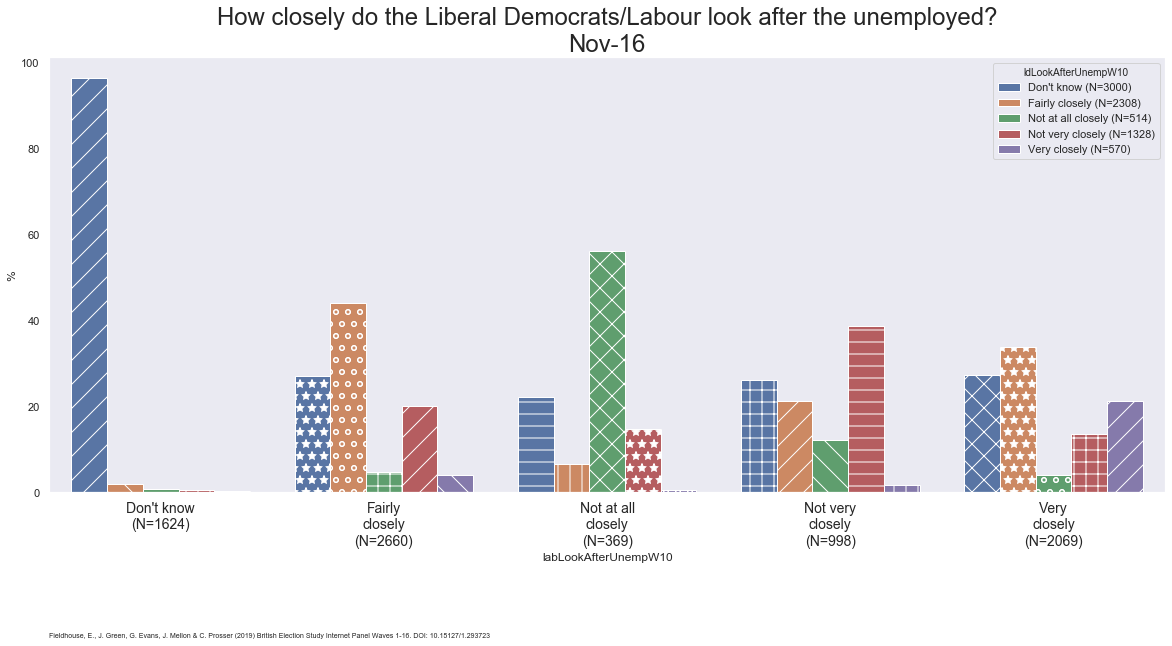

In [18]:
# VotedLabour2017 = BES_reduced_with_na["profile_past_vote_2017_Labour"]==1.0
global BES_Panel
wave = 10

var2 ="labLookAfterUnempW10"
var1 ="ldLookAfterUnempW10"


# df2 = govtHandouts
df2 = BES_Panel[var2]
#BES_Panel[var2]
df2 = df2.cat.rename_categories([str(x) for x in df2.cat.categories]) # force categories to be strings!
# df2.cat.rename_categories([str(x) for x in pan_dataset_ages[age_var].cat.categories],inplace=True)
df2.name = var2
df1 = BES_Panel[var1]

df1 = df1.cat.rename_categories([str(x) for x in df1.cat.categories])
df1.name = var1
print(df1.name)
# BES_Panel[var1]
# df1 = amalgamate_waves(BES_Panel,"immigSelf")#BES_Panel["immigSelfW14"]
# df1 = df1.cat.remove_categories(["Don't know"])
#amalgamate_waves(BES_Panel,"immigSelf")
# df2 = ever_voted_BNP
# BES_Panel[var2]#amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


date = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"].set_index("Wave No").loc[wave,"Date_Start"]

nice_bar_plot(df1, df2, min_sample_size=1, normalize='columns',drop_insig=False,
              text_width = 10,
              title_fontsize=24,
              char_limit=120,
              title="How closely do the Liberal Democrats/Labour look after the unemployed?"+"\n"+date)
#               mask = VotedLabour2017)




# # Define some hatches
# hatches = ['-', '+', 'x', '\\', '*', 'o']

# # Loop over the bars
# for i,thisbar in enumerate(bar.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[i])

In [66]:
search(BES_Panel,"LookAfterUnemp")

conLookAfterUnempW10     30237
labLookAfterUnempW10     30237
ukipLookAfterUnempW10    27710
snpLookAfterUnempW10      3397
pcLookAfterUnempW10       2001
ldLookAfterUnempW10       7720
grnLookAfterUnempW10      7720
dtype: int64

In [68]:
BES_Panel["ldLookAfterUnempW10"].value_counts()

Don't know            3000
Fairly closely        2308
Not very closely      1328
Very closely           570
Not at all closely     514
Name: ldLookAfterUnempW10, dtype: int64

In [ ]:
###################################

In [10]:
search(BES_Panel, "profile_past_vote|profile_eurefvote").index

profile_past_vote_2005    53351
profile_past_vote_2010    63248
profile_past_vote_2017    55241
profile_past_vote_2015    60846
profile_eurefvote         65871
dtype: int64

In [15]:
mask = BES_Panel[search(BES_Panel, "profile_past_vote|profile_eurefvote").index].notnull().all(axis=1)

In [16]:
best_weight_variable = search(BES_Panel,"wt_",mask=mask).sort_values(ascending=False).index[0]
best_weight_variable

'wt_new_W13_result'

In [26]:
nicer_euref_order = ["Leave the EU","Stay/remain in the EU","Don't know"]

CategoricalIndex(['Labour', 'Conservative', 'I would not vote',
                  'Liberal Democrat', 'Don't know',
                  'Scottish National Party (SNP)',
                  'United Kingdom Independence Party (UKIP)', 'Green Party',
                  'Plaid Cymru', 'Other', 'British National Party (BNP)'],
                 categories=['British National Party (BNP)', 'Conservative', 'Don't know', 'Green Party', 'I would not vote', 'Labour', 'Liberal Democrat', 'Other', ...], ordered=False, dtype='category')

In [31]:
GE_var = "profile_past_vote_2005"
ct = pd.crosstab(index   = BES_Panel[GE_var],
   columns = BES_Panel["profile_eurefvote"],
   values  = BES_Panel[ best_weight_variable ],
   aggfunc = sum,
   normalize='index')
(ct.loc[BES_Panel[GE_var].value_counts().index,nicer_euref_order]*100).round(2)

profile_eurefvote,Leave the EU,Stay/remain in the EU,Don't know
profile_past_vote_2005,,,
Labour,45.07,53.94,0.99
Conservative,68.93,30.29,0.78
I would not vote,55.26,42.87,1.87
Liberal Democrat,40.75,58.14,1.11
Don't know,56.37,40.29,3.35
Scottish National Party (SNP),43.57,55.72,0.71
United Kingdom Independence Party (UKIP),90.67,8.06,1.27
Green Party,36.14,61.24,2.62
Plaid Cymru,43.36,53.51,3.13


In [32]:
GE_var = "profile_past_vote_2010"
ct = pd.crosstab(index   = BES_Panel[GE_var],
   columns = BES_Panel["profile_eurefvote"],
   values  = BES_Panel[ best_weight_variable ],
   aggfunc = sum,
   normalize='index')
(ct.loc[BES_Panel[GE_var].value_counts().index,nicer_euref_order]*100).round(2)

profile_eurefvote,Leave the EU,Stay/remain in the EU,Don't know
profile_past_vote_2010,,,
Conservative,66.57,32.29,1.14
Labour,40.36,58.91,0.72
Liberal Democrat,35.32,63.30,1.38
I would not vote,53.62,45.09,1.29
Scottish National Party (SNP),39.16,59.49,1.35
Don't know,51.92,41.10,6.98
United Kingdom Independence Party (UKIP),94.23,5.66,0.11
Green Party,32.43,65.99,1.58
Other,54.79,40.58,4.63


In [33]:
GE_var = "profile_past_vote_2015"
ct = pd.crosstab(index   = BES_Panel[GE_var],
   columns = BES_Panel["profile_eurefvote"],
   values  = BES_Panel[ best_weight_variable ],
   aggfunc = sum,
   normalize='index')
(ct.loc[BES_Panel[GE_var].value_counts().index,nicer_euref_order]*100).round(2)

profile_eurefvote,Leave the EU,Stay/remain in the EU,Don't know
profile_past_vote_2015,,,
Conservative,60.89,38.18,0.92
Labour,32.88,66.29,0.82
United Kingdom Independence Party (UKIP),94.68,4.63,0.69
Liberal Democrat,33.06,66.43,0.50
Scottish National Party (SNP),35.99,63.29,0.72
Green Party,19.04,80.23,0.73
Don't know,46.33,36.63,17.04
Other,46.74,46.20,7.05
Plaid Cymru,28.77,67.30,3.94


In [34]:
GE_var = "profile_past_vote_2017"
ct = pd.crosstab(index   = BES_Panel[GE_var],
   columns = BES_Panel["profile_eurefvote"],
   values  = BES_Panel[ best_weight_variable ],
   aggfunc = sum,
   normalize='index')
(ct.loc[BES_Panel[GE_var].value_counts().index,nicer_euref_order]*100).round(2)

profile_eurefvote,Leave the EU,Stay/remain in the EU,Don't know
profile_past_vote_2017,,,
Conservative,72.52,26.70,0.78
Labour,31.01,68.28,0.71
Liberal Democrat,19.67,79.12,1.21
Scottish National Party (SNP),24.45,75.35,0.20
United Kingdom Independence Party (UKIP),96.16,3.79,0.05
Green Party,34.11,64.52,1.37
Don't know,38.56,29.14,32.30
Other,58.97,31.34,9.69
Plaid Cymru,46.02,53.03,0.96


In [ ]:
### Income by party preference

In [172]:
search(BES_Panel,"profile_gross_personal")

profile_gross_personal    57404
dtype: int64

In [173]:
search(BES_Panel,"generalElectionVoteW16")

generalElectionVoteW16    37959
dtype: int64

In [186]:
profile_gross_personal = BES_Panel["profile_gross_personal"].cat.reorder_categories(['under Â£5,000 per year',
       'Â£5,000 to Â£9,999 per year', 'Â£10,000 to Â£14,999 per year', 
       'Â£15,000 to Â£19,999 per year', 'Â£20,000 to Â£24,999 per year',
       'Â£25,000 to Â£29,999 per year', 'Â£30,000 to Â£34,999 per year',
       'Â£35,000 to Â£39,999 per year', 'Â£40,000 to Â£44,999 per year',
       'Â£45,000 to Â£49,999 per year', 
       'Â£50,000 to Â£59,999 per year', 'Â£60,000 to Â£69,999 per year',
       'Â£70,000 to Â£99,999 per year','Â£100,000 and over',"Don't know", 'Prefer not to answer', ])
profile_gross_personal = profile_gross_personal.apply(lambda x: x.replace("Â",""))

In [187]:
var1 = BES_Panel['generalElectionVoteW16']
var2 = profile_gross_personal
mask = var1.notnull()&var2.notnull()
best_weight_variable = search(BES_Panel,"wt_",mask=mask).sort_values(ascending=False).index[0]
best_weight_series = BES_Panel[best_weight_variable]
print(best_weight_variable)

ct = pd.crosstab(index = var1[mask],
            columns = var2[mask],
            values = best_weight_series[mask],
            aggfunc = np.sum,
            normalize='index')
round(ct*100,0).astype('int')

wt_new_W16


profile_gross_personal,"under £5,000 per year","£5,000 to £9,999 per year","£10,000 to £14,999 per year","£15,000 to £19,999 per year","£20,000 to £24,999 per year","£25,000 to £29,999 per year","£30,000 to £34,999 per year","£35,000 to £39,999 per year","£40,000 to £44,999 per year","£45,000 to £49,999 per year","£50,000 to £59,999 per year","£60,000 to £69,999 per year","£70,000 to £99,999 per year","£100,000 and over",Don't know,Prefer not to answer
generalElectionVoteW16,,,,,,,,,,,,,,,,
I would not vote,10,15,12,12,8,6,3,2,2,0,1,1,0,0,7,19
Conservative,6,9,12,10,10,9,6,4,4,2,3,1,2,1,3,19
Labour,13,13,13,11,9,8,5,3,2,1,1,0,1,0,4,15
Liberal Democrat,8,8,10,9,10,8,8,5,4,3,4,2,2,1,4,16
Scottish National Party (SNP),12,9,14,12,10,8,7,4,2,1,1,1,1,0,3,16
Plaid Cymru,7,9,11,21,11,7,4,6,1,0,0,1,0,1,5,16
United Kingdom Independence Party (UKIP),16,17,16,12,5,6,2,2,0,0,1,0,0,0,6,16
Green Party,14,9,13,11,11,8,5,3,3,2,1,2,1,0,4,13
Other,6,9,7,11,9,6,5,6,3,2,2,1,1,1,2,30


Text(0.5, 1.0, 'GE Voting Intention (Con&Lab) May 2019 by Gross Personal Income')

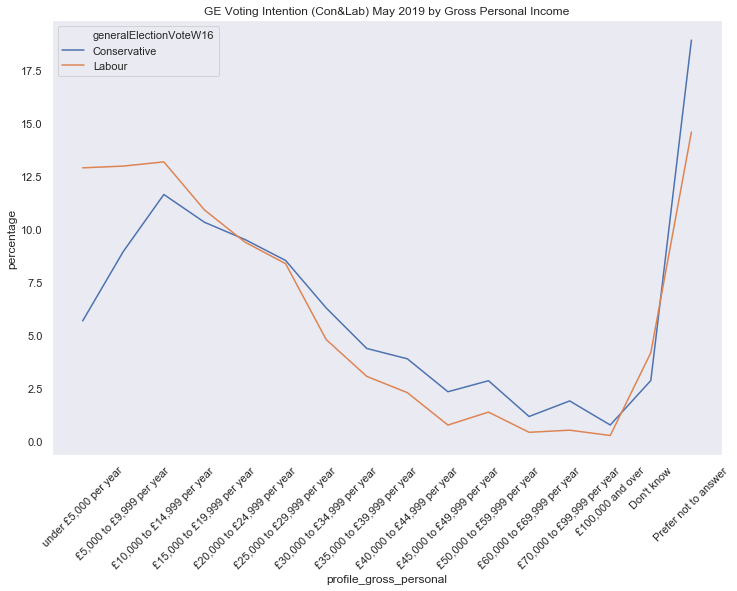

In [206]:
# sns.lineplot(data = ct.loc[["Conservative","Labour"]].reset_index())
plt.figure(figsize=(12,8))
df = (ct*100).loc[["Conservative","Labour"]].stack().reset_index().rename(columns={0:'percentage'})
df['generalElectionVoteW16'].cat.remove_unused_categories(inplace=True)
sns.lineplot(data=df, x='profile_gross_personal',hue='generalElectionVoteW16', y='percentage');
plt.xticks(rotation=45);
plt.title("GE Voting Intention (Con&Lab) May 2019 by Gross Personal Income");

In [215]:
var1 = BES_Panel['generalElectionVoteW16']
var2 = pan_dataset_ages["equalisedAgeGroup_at_W1"]
mask = var1.notnull()&var2.notnull()
best_weight_variable = search(BES_Panel,"wt_",mask=mask).sort_values(ascending=False).index[0]
best_weight_series = BES_Panel[best_weight_variable]
print(best_weight_variable)

ct = pd.crosstab(index = var1[mask],
            columns = var2[mask],
            values = best_weight_series[mask],
            aggfunc = np.sum,
            normalize='index')
round(ct*100,0).astype('int')

wt_new_W16


equalisedAgeGroup_at_W1,"(12.0, 22.0]","(22.0, 30.0]","(30.0, 38.0]","(38.0, 46.0]","(46.0, 53.0]","(53.0, 60.0]","(60.0, 66.0]","(66.0, 95.0]"
generalElectionVoteW16,,,,,,,,
I would not vote,11,19,18,19,10,9,8,5
Conservative,8,7,10,14,11,13,17,20
Labour,21,16,16,15,10,9,7,5
Liberal Democrat,17,13,16,15,10,10,10,8
Scottish National Party (SNP),14,11,14,18,13,12,11,6
Plaid Cymru,18,13,9,16,12,13,13,6
United Kingdom Independence Party (UKIP),18,15,16,15,12,9,9,7
Green Party,29,17,15,14,9,7,6,3
Other,12,10,11,16,11,15,16,9


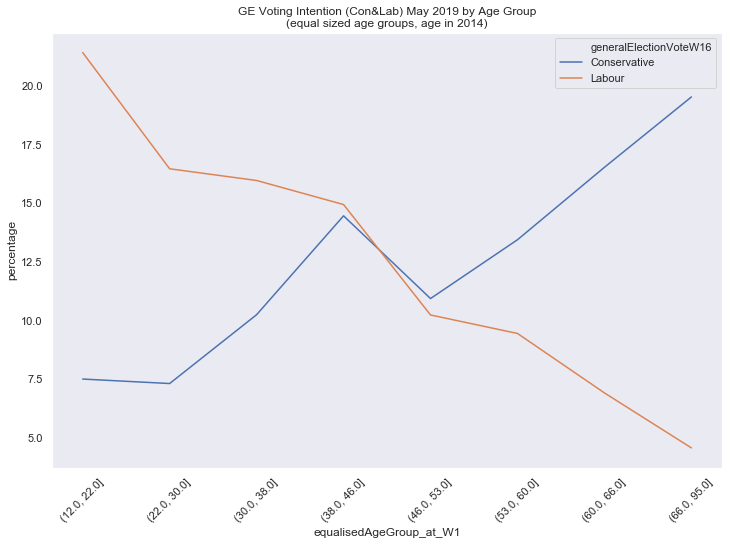

In [216]:
# sns.lineplot(data = ct.loc[["Conservative","Labour"]].reset_index())
plt.figure(figsize=(12,8))
df = (ct*100).loc[["Conservative","Labour"]].stack().reset_index().rename(columns={0:'percentage'})
df['generalElectionVoteW16'].cat.remove_unused_categories(inplace=True)
sns.lineplot(data=df, x='equalisedAgeGroup_at_W1',hue='generalElectionVoteW16', y='percentage');
plt.xticks(rotation=45);
plt.title("GE Voting Intention (Con&Lab) May 2019 by Age Group\n(equal sized age groups, age in 2014)");

wt_new_W16


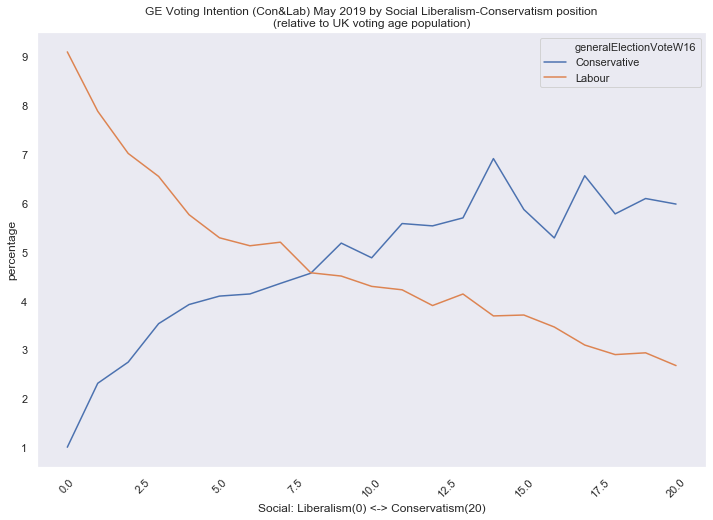

In [247]:
var1 = BES_Panel['generalElectionVoteW16']
var2 = pan_dataset_allr_values[y_axis]
mask = var1.notnull()&var2.notnull()
best_weight_variable = search(BES_Panel,"wt_",mask=mask).sort_values(ascending=False).index[0]
best_weight_series = BES_Panel[best_weight_variable]
print(best_weight_variable)

ct = pd.crosstab(index = var1[mask],
            columns = var2[mask],
            values = best_weight_series[mask],
            aggfunc = np.sum,
            normalize='index')
# round(ct*100,0).astype('int')

# sns.lineplot(data = ct.loc[["Conservative","Labour"]].reset_index())
plt.figure(figsize=(12,8))
df = (ct*100).loc[["Conservative","Labour"]].stack().reset_index().rename(columns={0:'percentage'})
df['generalElectionVoteW16'].cat.remove_unused_categories(inplace=True)
sns.lineplot(data=df, x=y_axis,hue='generalElectionVoteW16', y='percentage');
plt.xticks(rotation=45);
plt.xlabel(y_axis.split("{")[0])
plt.title("GE Voting Intention (Con&Lab) May 2019 by Social Liberalism-Conservatism position\n(relative to UK voting age population)");

'Economic: Left(0) <-> Right(20)'

In [ ]:
x_var = 'Economic: Left <-> Right{gaussian-ish}'
y_var = 'Social: Liberalism <-> Conservatism{gaussian-ish}'
x_axis = pan_dataset_allr_values.columns[0].replace("200",str(granularity-1)).replace("{uniform}","")+"{"+best_weight_variable+"}"
y_axis = pan_dataset_allr_values.columns[1].replace("200",str(granularity-1)).replace("{uniform}","")+"{"+best_weight_variable+"}"



In [ ]:
### Looking at social grade breakdowns - curious about age splits

In [13]:
search(BES_Panel,"profile_socgrade").index

Index(['profile_socgradeW7', 'profile_socgradeW8', 'profile_socgradeW12',
       'profile_socgradeW13', 'profile_socgradeW14', 'profile_socgradeW15',
       'profile_socgradeW16'],
      dtype='object')

In [10]:
pan_dataset_ages = pd.read_csv( BES_small_data_files + "pan_dataset_ages"+".csv" )
pan_dataset_ages["equalisedAgeGroup_at_W1"].value_counts()

(30.0, 38.0]    11688
(38.0, 46.0]    11603
(60.0, 66.0]    11583
(12.0, 22.0]    11583
(53.0, 60.0]    11573
(22.0, 30.0]    11564
(66.0, 95.0]    11563
(46.0, 53.0]    11427
Name: equalisedAgeGroup_at_W1, dtype: int64

In [14]:
var1 = BES_Panel['profile_socgradeW16']
var2 = pan_dataset_ages["equalisedAgeGroup_at_W1"]
mask = var1.notnull()
best_weight_variable = search(BES_Panel,"wt_",mask=mask).sort_values(ascending=False).index[0]
best_weight_series = BES_Panel[best_weight_variable]
print(best_weight_variable)

ct = pd.crosstab(index = var1[mask],
            columns = var2[mask],
            values = best_weight_series[mask],
            aggfunc = np.sum,
            normalize='index')
round(ct*100,0).astype('int')

wt_new_W16


equalisedAgeGroup_at_W1,"(12.0, 22.0]","(22.0, 30.0]","(30.0, 38.0]","(38.0, 46.0]","(46.0, 53.0]","(53.0, 60.0]","(60.0, 66.0]","(66.0, 95.0]"
profile_socgradeW16,,,,,,,,
a,15,9,14,14,10,12,13,13
b,13,14,16,16,9,10,12,9
C1,18,14,14,15,11,10,10,8
C2,11,12,13,16,13,13,12,10
d,14,14,17,18,12,11,10,6
e,7,8,12,14,12,14,17,15


In [ ]:
# pattern not superclear

In [12]:
search(BES_Panel,"profile_work_type")

profile_work_typeW7W10    38008
profile_work_typeW11      30956
profile_work_typeW14      31063
profile_work_typeW2_W4     8592
dtype: int64

Warning, filename truncated because it was over 60. Filenames may no longer be unique


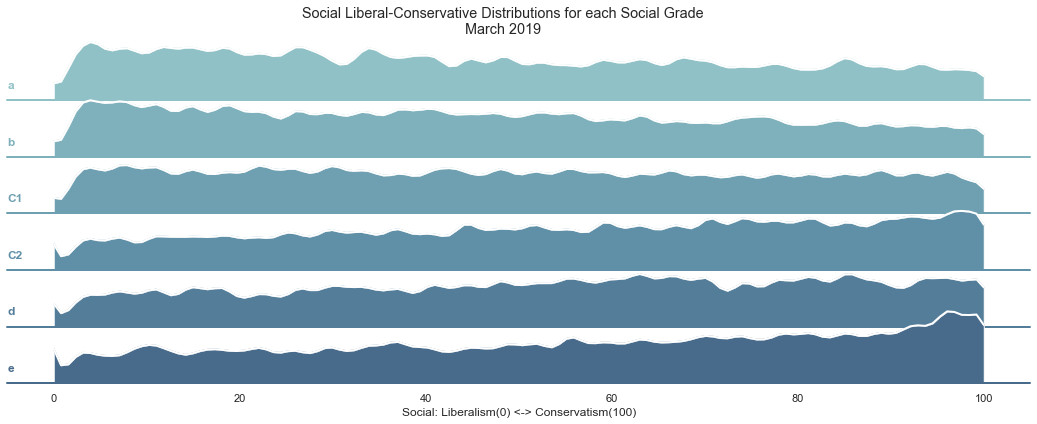

In [253]:
Treatment = "Ridgeplot"
output_subfolder = create_subdir(BES_output_folder,Treatment)

var1 = 'profile_socgradeW16'
ser1 = BES_Panel[var1]
var2 = y_axis
ser2 = pan_dataset_allr_values[var2]
title = "Social Liberal-Conservative Distributions for each Social Grade\nMarch 2019"

# var2 = "Age_at_W1"
# ser2 = pan_dataset_ages["Age_at_W1"]+5
# title = "Age Distributions for each Social Grade\nMarch 2019"

fname = output_subfolder +clean_filename(var1+"_by_"+var2 + ".png", char_limit=60)
# this will save the figure as a high-res png. you can also save as svg

ridge_plot(ser1,  ser2, title=title, bw=1)
plt.xlabel(var2.split("{")[0])
plt.savefig( fname, bbox_inches='tight', dpi=300)

In [249]:
def ridge_plot(ser1,ser2, *args, **kwargs):
    global BES_Panel
    lazy_weighting = kwargs.get('lazy_weighting', True)
    title = kwargs.get('title', ser1.name+"_by_"+ser2.name)
    bw = kwargs.get('bw', 1)
#     perc = kwargs.get('perc', False)
#     decimal_places = kwargs.get('decimal_places', 2)
#     suppress_raw_samplesize = kwargs.get('suppress_raw_samplesize', False)    
    
    sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    var1=ser1.name
    var2=ser2.name
    mask = ser1.notnull()&ser2.notnull()

    df = pd.concat([ser2[mask], ser1[mask]] ,axis=1)

    # lazy weighting!
    if lazy_weighting:
        best_weight_variable = search(BES_Panel,"wt_",mask=mask).sort_values(ascending=False).index[0]
        best_weight_series = BES_Panel[best_weight_variable][mask]
        df.loc[lazy_weighted_indices(best_weight_series[mask])]

    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(df, row=var1, hue=var1, aspect=15, height=1, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, var2, clip_on=False, shade=True, alpha=1, lw=1.5, bw=bw,cut=0)
    g.map(sns.kdeplot, var2, clip_on=False, color="w", lw=2, bw=bw,cut=0)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, var2);

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.25);

    # Remove axes details that don't play well with overlap
    g.set_titles("");
    g.set(yticks=[]);

    g.despine(bottom=True, left=True);
    # plt.suptitle("Age Distributions for each Social Grade\nMarch 2019")

    plt.xlabel(var2);
    g.fig.suptitle(title);

In [ ]:
weights = best_weight_series[mask]

In [137]:
mask = BES_Panel["welfarePreferenceW14"].notnull()

best_weight_variable = search(BES_Panel,"wt_",mask=mask).sort_values(ascending=False).index[0]
best_weight_series = BES_Panel[best_weight_variable]
print(best_weight_variable)
weighted_value_counts(BES_Panel["welfarePreferenceW14"][mask],best_weight_series[mask],
                      normalize=False, perc=True, decimal_places=0, ascending=False)

wt_new_W14


,weighted_sample_size,raw_sample_size
welfarePreferenceW14,,
Don't know,7220,6474
About right,7123,7547
Too high,6443,6514
Too low,5346,5630
Much too high,2751,2677
Much too low,2172,2221


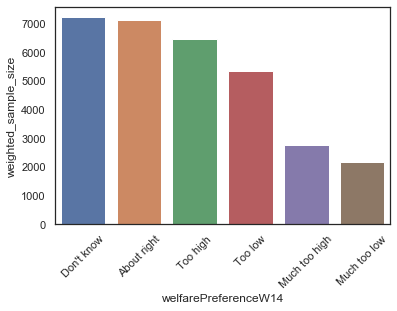

In [140]:
df = weighted_value_counts(BES_Panel["welfarePreferenceW14"][mask],best_weight_series[mask],
                      normalize=False, perc=True, decimal_places=0, ascending=False)
sns.barplot(data = df.reset_index(), x="welfarePreferenceW14",y="weighted_sample_size", order=df.index);
plt.xticks(rotation=45);

In [ ]:
###### random question about Leave/Remain "sense of control"

In [ ]:
#### how much can you predict voting behaviour based on 2D political values?

In [ ]:
# wave 6


X = bankdata.drop('Class', axis=1)
y = bankdata['Class']

In [27]:
BES_Panel["generalElectionVoteW6"].value_counts()

y = BES_Panel["generalElectionVoteW6"]
mask = y.apply(lambda x: x in ["Labour","Conservative"])==True
y = y[mask].replace("Labour",0).replace("Conservative",1)
X = pan_dataset_allr_values[ pan_dataset_allr_values.columns[0:2] ][mask]

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [34]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [35]:
y_pred = svclassifier.predict(X_test)

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1357  412]
 [ 347 1358]]
              precision    recall  f1-score   support

           0       0.80      0.77      0.78      1769
           1       0.77      0.80      0.78      1705

    accuracy                           0.78      3474
   macro avg       0.78      0.78      0.78      3474
weighted avg       0.78      0.78      0.78      3474



In [ ]:
## Scottish Labour 2010 split by 2014

In [41]:
search (BES_Panel, "scotref")

scotReferendumOutsideW1        24450
scotReferendumIntentionW1       5873
scotReferendumTurnoutW1         5872
scotRefExpectationW1            9348
scotRefExpectationTurnoutW1     5872
scotReferendumOutsideW2        24191
scotReferendumIntentionW2       6046
scotReferendumTurnoutW2         6045
scotRefExpectationW2            9653
scotRefExpectationTurnoutW2     6046
expectGoodConductScotRefW2      6046
scotReferendumRetroW3           5262
scotReferendumVoteW3            5080
goodConductScotRefW3            5213
scotReferendumIntentionW4       5409
scotReferendumIntentionW6       5334
scotReferendumIntentionW7       4215
scotReferendumIntentionW9       3892
scotReferendumIntentionW10      3397
scotRefIDW10                    3397
scotRefID1W10                   2937
scotRefID2W10                   2937
scotRefID3W10                   2937
scotRefID4W10                   2937
scotRefID6W10                   2937
scotRefID7W10                   2937
scotReferendumIntentionW11      3793
s

In [42]:
BES_Panel["profile_scotref_vote"].value_counts()

I voted 'No' (Scotland should not be an independent country)    4704
I voted 'Yes' (Scotland should be an independent country)       4070
Don't know                                                        25
Name: profile_scotref_vote, dtype: int64

In [76]:
Labour2010ScotRef2014 = (BES_Panel["profile_past_vote_2010"]=="Labour") & BES_Panel["profile_scotref_vote"].notnull()
weighted_value_counts(BES_Panel["profile_scotref_vote"][Labour2010ScotRef2014],
                      BES_Panel["wt_new_W16"][Labour2010ScotRef2014],normalize=True,perc=True)

,weighted_sample_percentage,raw_sample_size
profile_scotref_vote,,
Don't know,0.00,0.0
I voted 'Yes' (Scotland should be an independent country),30.36,154.0
I voted 'No' (Scotland should not be an independent country),69.64,365.0


In [58]:
(Labour2010ScotRef2014&BES_Panel["wt_new_W8"].notnull()).sum()

1004